### Imports

This notebook employs standard data science and ML libraries (`numpy`, `pandas`, `scikit-learn`) and visualization libraries (`matplotlib` and `seaborn`).

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

import os

# plot formatting
plt.style.use('bmh')
plt.rcParams['font.size'] = 12

### Load Data

We'll load the raw csv file into a pandas dataframe for exploration. Based on the metadata, we know that the column 'Property Id' is unique for each row and so we set that as the index column. We'll start exploring some basic features about dataset by inspecting the first few rows, inspecting the shape of the dataset, and sifting through columns that are already set with a numerical data type. 

In [2]:
# Read in raw data file
#data = pd.read_csv("../data/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv", index_col="Property Id")
data = pd.read_csv("../data/NYC_Building_Energy_and_Water_Data_Disclosure_for_Local_Law_84__2022-Present__20250609.csv", index_col="Property ID")

/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_94947/3132887344.py:3: DtypeWarning: Columns (10,16,32,34,42,61,76,77,78,79,80,81,82,91,174,239,240,241,242,243,244,245,246,247,248) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/NYC_Building_Energy_and_Water_Data_Disclosure_for_Local_Law_84__2022-Present__20250609.csv", index_col="Property ID")


In [3]:
# Print first few lines
data.head()

,Calendar Year,Property Name,Parent Property ID,Parent Property Name,Year Ending,"NYC Borough, Block and Lot (BBL)",NYC Building Identification Number (BIN),Address 1,City,Postal Code,Primary Property Type - Self Selected,Primary Property Type - Portfolio Manager-Calculated,National Median Reference Property Type,List of All Property Use Types (GFA) (ft²),Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use Type - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Construction Status,Number of Buildings,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,National Median ENERGY STAR Score,Target ENERGY STAR Score,Reason(s) for No Score,...,Municipally Supplied Potable Water - Outdoor Use (kgal),Third Party Certification,Third Party Certification Date Anticipated,Third Party Certification Date Achieved,Data Quality Checker Run?,Data Quality Checker - Date Run,Last Modified Date - Property,Last Modified Date - Electric Meters,Electric Distribution Utility,Last Modified Date - Gas Meters,Last Modified Date - Non-Electric Non-Gas Energy Meters,Last Modified Date - Water Meters,Last Modified Date - Property Use,Last Modified Date - Property Use Details,Number of Active Energy Meters - Total,Number of Active Energy Meters - Used to Compute Metrics,Number of Active Energy Meters - Not Used to Compute Metrics,Number of Active IT Meters,Aggregate Meter(s)-Electric – Number of Individual Meters Included,Aggregate Meter(s)-Natural Gas – Number of Individual Meters Included,Aggregate Meter(s)-District Steam – Number of Individual Meters Included,Report Generation Date,Report Submission Date,Borough,Latitude,Longitude,Community Board,Council District,Census Tract (2020),Neighborhood Tabulation Area (NTA) (2020)
Property ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6414946,2022,58-01 Grand Avenue,Not Applicable: Standalone Property,Not Applicable: Standalone Property,12/31/2022,4026780001,4059918,58-01 Grand Avenue,Queens,11378,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,CBECS - Non-Refrigerated Warehouse,Non-Refrigerated Warehouse (51749.0),Non-Refrigerated Warehouse,51749,Not Available,Not Available,Not Available,Not Available,1930,Existing,1,50,Whole Property,Whole Property,96,50,Not Available,Not Available,...,Not Available,Not Available,Not Available,Not Available,NaN,NaN,04/24/2023 12:00:00 AM,04/24/2023 12:00:00 AM,NaN,04/07/2023 12:00:00 AM,NaN,03/10/2023 12:00:00 AM,06/10/2021 12:00:00 AM,06/10/2021 12:00:00 AM,3,3,0,0,NaN,NaN,NaN,04/25/2023 11:01:00 AM,04/25/2023 11:02:00 AM,QUEENS,40.719667,-73.911197,405.0,30.0,531.0,QN0501
9793770,2022,1870 Pelham Parkway South,Not Applicable: Standalone Property,Not Applicable: Standalone Property,12/31/2022,2042500026,2047795,1870 Pelham Parkway South,Bronx,10461,Multifamily Housing,Multifamily Housing,Fannie Mae Industry Survey - Multifamily,Multifamily Housing (52941.0),Multifamily Housing,52941,Not Available,Not Available,Not Available,Not Available,1960,Existing,1,75,Whole Property,Whole Property,61,50,Not Available,Not Available,...,Not Available,Not Available,Not Available,Not Available,NaN,NaN,03/10/2023 12:00:00 AM,03/10/2023 12:00:00 AM,NaN,03/10/2023 12:00:00 AM,NaN,02/24/2023 12:00:00 AM,03/28/2022 12:00:00 AM,03/28/2022 12:00:00 AM,4,4,0,0,NaN,NaN,NaN,03/11/2023 02:00:00 PM,03/11/2023 02:01:00 PM,BRONX,40.855488,-73.830726,210.0,13.0,300.0,BX1003
10177418,2022,Central Building,Not Applicable: Standalone Property,Not Applicable: Standalone Property,12/31/2022,4157040040,4300145,2011 Mott Ave,Far Rockaway,11691,Mixed Use Property,Mixed Use Property,CBECS - Other,"Office (17598.0), Retail Store (17598.0)",Office,17598,Retail Store,17598,Not Available,Not Available,1941,Existing,1,50,Whole Property,Whole Property,Not Available,50,Not Available,More than 50% of the Gross Floor Area is not a...

Next we'll print some basic information about the dataset: its shape, features, and summary statistics.

In [4]:
# Shape information 
print(f"Shape of dataset: {data.shape}")

# Numeric features
numeric_cols = data.select_dtypes(include=['number']).columns
print("\nNumeric Columns:",  numeric_cols)

# Numeric features
nonnumeric_cols = data.select_dtypes(exclude=['number']).columns
print("\nNon-numeric Columns:",  nonnumeric_cols)

Shape of dataset: (64169, 264)

Numeric Columns: Index(['Calendar Year', 'Year Built', 'Number of Buildings', 'Occupancy',
       'National Median ENERGY STAR Score',
       'Property GFA - Self-Reported (ft²)',
       'Property GFA - Calculated (Buildings and Parking) (ft²)',
       'Property GFA - Calculated (Buildings) (ft²)',
       'Number of Active Energy Meters - Total',
       'Number of Active Energy Meters - Used to Compute Metrics',
       'Number of Active Energy Meters - Not Used to Compute Metrics',
       'Number of Active IT Meters',
       'Aggregate Meter(s)-Electric – Number of Individual Meters Included',
       'Aggregate Meter(s)-Natural Gas – Number of Individual Meters Included',
       'Aggregate Meter(s)-District Steam – Number of Individual Meters Included',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract (2020)'],
      dtype='object')

Non-numeric Columns: Index(['Property Name', 'Parent Property ID', 'Parent Prop

Looking at the cell above, we see that there are many columns which hold numerical data, such as those in units of ft² and kBtu. Based on the `data.head()` information, we also know that missing data are indicated with cells that store the string `"Not Available."`. Let's start the data cleaning process by first changing all missing values to `nan`. Next we'll identify columns that store numerical data by checking if they contain a unit (energy, volume, mass, etc.) and convert them to `float` types. Then we can view summary stats for all numeric columns with `data.describe()`.

In [5]:
# replace all instances of 'Not Available' with nan
data = data.replace({'Not Available': np.nan})

# We'll also manually add the ENERGY STAR Score column

units = ['ft', 'kBtu', 'Number of', 'Percent', 'Hours', 'gal', 'Tons', 'kWh', 'ENERGY STAR Score', 'kgal']

for col in data.columns:
    # check if there are any units or any other indication that this column is numeric
    for token in units:
        if token in col:
            try:
                data[col] = data[col].astype(float)
            except:
                print(f"Couldn't convert column '{col}'.")

# summary stats on numeric columns
data.describe()


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_94947/2940800074.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({'Not Available': np.nan})


Couldn't convert column 'List of All Property Use Types (GFA) (ft²)'.
Couldn't convert column 'Alert - Gross Floor Area is 0 ft2'.


,Calendar Year,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings,Occupancy,ENERGY STAR Score,National Median ENERGY STAR Score,Target ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),National Median Site EUI (kBtu/ft²),Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),Electricity - Weather Normalized Site Electricity Use (Grid and Onsite Renewables) (kWh),Electricity - Weather Normalized Site Electricity Intensity (Grid and Onsite Renewables) (kWh/ft²),Percent Electricity,Natural Gas - Weather Normalized Site Natural Gas Intensity (therms/ft²),Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),National Median Source EUI (kBtu/ft²),Source Energy Use (kBtu),Weather Normalized Source Energy Use (kBtu),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Propane Use (kBtu),...,Supermarket/Grocery - Gross Floor Area (ft²),Supermarket/Grocery - Number of Walk-in Refrigeration/Freezer Units,Supermarket/Grocery - Number of Open or Closed Refrigeration/Freezer Units,Wholesale Club/Supercenter- Gross Floor Area (ft²),Wastewater Treatment Plant - Gross Floor Area (ft²),Worship Facility - Gross Floor Area (ft²),Strip Mall - Gross Floor Area (ft²),Property GFA - Self-Reported (ft²),Property GFA - Calculated (Buildings and Parking) (ft²),Property GFA - Calculated (Buildings) (ft²),Property GFA - Calculated (Parking) (ft²),Water Use (All Water Sources) (kgal),Indoor Water Use (All Water Sources) (kgal),Outdoor Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Mixed Indoor/Outdoor Use (kgal),Municipally Supplied Potable Water - Total Use (All Meter Types) (kgal),Municipally Supplied Potable Water - Indoor Use (kgal),Municipally Supplied Potable Water - Outdoor Use (kgal),Number of Active Energy Meters - Total,Number of Active Energy Meters - Used to Compute Metrics,Number of Active Energy Meters - Not Used to Compute Metrics,Number of Active IT Meters,Aggregate Meter(s)-Electric – Number of Individual Meters Included,Aggregate Meter(s)-Natural Gas – Number of Individual Meters Included,Aggregate Meter(s)-District Steam – Number of Individual Meters Included,Latitude,Longitude,Community Board,Council District,Census Tract (2020)
count,64169.000000,6.414000e+04,1.562800e+04,5.827000e+03,64169.000000,64169.000000,64169.000000,49039.000000,64169.0,10328.000000,5.977800e+04,5.668600e+04,62848.000000,5.979000e+04,5.669800e+04,5.856000e+04,58560.000000,30022.000000,55510.000000,5.977800e+04,5.668600e+04,62848.000000,5.979000e+04,5.669800e+04,1.400000e+01,9.918000e+03,2.785000e+03,2.500000e+01,2.390000e+02,0.0,...,842.000000,842.000000,842.000000,50.000000,2.800000e+01,6.530000e+02,401.000000,6.416900e+04,6.415700e+04,6.415700e+04,5.768000e+03,4.081600e+04,4.014100e+04,18.000000,7.290000e+02,4.080300e+04,4.013600e+04,9.000000,64169.000000,64169.000000,64169.000000,64169.000000,33684.000000,33684.0,33684.0,61790.000000,61790.000000,61791.000000,61791.000000,61791.000000
mean,2022.524926,1.227246e+05,2.462796e+04,1.542098e+04,1951.318814,1.308404,97.057224,62.295520,50.0,82.710302,7.964434e+03,9.252251e+03,82.492838,1.405560e+07,1.354626e+07,1.110687e+06,50.650015,39.149294,93.233144,8.655923e+03,1.002516e+04,137.202473,2.168458e+07,2.097218e+07,2.197151e+06,2.646878e+06,4.486526e+06,3.140754e+06,2.056323e+06,NaN,...,22149.907601,5.032268,17.352506,125602.660000,7.066872e+05,7.724994e+04,54502.825436,1.289762e+05,1.314226e+05,1.288583e+05,3.435926e+04,6.052381e+03,5.630025e+03,6990.100000,2.893483e+04,6.044073e+03,5.630362e+03,1041.300000,7.177173,6.931961,0.245212,0.003241,0.000475,0.0,0.0,40.747879,-73.936054,236.232137,19.794096,9067.082391
std,0.499382,2.971832e+05,7.982824e+04,5.300921e+04,35.262775,4.311709,12.332866,28.986061,0.0,10.198719,2.327075e+05,2.625213e+05,

The definition for columns regarding 'metered areas' is a bit unclear, so we can inspect those columns by checking what unique values they store. Based on the results, a reasonable assumption is that metered areas refers to areas of the building for which energy and water usage data is measurable.

In [6]:
print("\nUnique values for 'Metered Areas (Water)':\n", data['Metered Areas (Water)'].unique())

print("\nUnique values for 'Metered Areas (Energy)':\n", data['Metered Areas (Energy)'].unique())


Unique values for 'Metered Areas (Water)':
 ['Whole Property' nan 'Another configuration'
 'Common areas (all energy loads)'
 'Tenant and/or common areas (partial energy loads)'
 'Tenant areas (all energy loads)']

Unique values for 'Metered Areas (Energy)':
 ['Whole Property' nan 'Common areas (all energy loads)'
 'Another configuration' 'Common Area Heating, Tenant Heating'
 'Tenant Heating, Common Area Heating' 'Tenant areas (all energy loads)'
 'Tenant Hot Water, Common Area Heating, Tenant Heating, Common Area Hot Water'
 'Common Area Cooling, Common Area Hot Water, Tenant Hot Water, Common Area Heating, Tenant Heating, Common Area Plug Load/Electricity']


We want to predict the "ENERGY STAR Score" column for unseen data points (NYC properties). Looking at the cells above, we see that this column is classified as non-numeric. To investigate, clean, and convert this column, let's print the first few values.

The official definition of the target column is as follows, directly taken from this [link](https://data.cityofnewyork.us/Environment/NYC-Building-Energy-and-Water-Data-Disclosure-for-/5zyy-y8am/about_data). "The 1-100 scale is set so that 1 represents the worst performing buildings and 100 represents the best performing buildings. A score of 50 indicates that a building is performing at the national median, taking into account its size, location, and operating parameters. A score of 75 indicates that a property is performing in the 75th percentile and may be eligible to earn ENERGY STAR Certification. ENERGY STAR Scores are available for many property types. The 1-100 scale is based on the country in which your property is located. "

In [7]:
data['ENERGY STAR Score'].head(15)

Property ID
6414946     96.0
9793770     61.0
10177418     NaN
13511507    64.0
14009907    98.0
14377690    61.0
14965065    83.0
15104433    58.0
15176247    16.0
15176327    71.0
15176328    37.0
15176329    32.0
15288692    40.0
15288693    51.0
15304524    18.0
Name: ENERGY STAR Score, dtype: float64

In [8]:
def missing_values(df):
    # total missing values per column
    total_missing = df.isnull().sum()

    # percentage of missing values
    percent_missing = 100* (total_missing / len(df))

    # missing value table
    table = pd.concat([total_missing, percent_missing], axis=1)

    # rename the columns
    table = table.rename(
        columns = {0: 'Missing Values', 1: '% of Total'}
    )

    # sort by percentage, descending
    table = table.sort_values(by='% of Total', ascending=False)

    # print summmary information
    print(f"Dataframe has {df.shape[1]} columns.")
    print(f"{len(table[table['% of Total']!=0])} columns have missing information.")

    return table

In [9]:
missing_data_table = missing_values(data)

Dataframe has 264 columns.
230 columns have missing information.


Text(0, 0.5, 'Number of Columns')

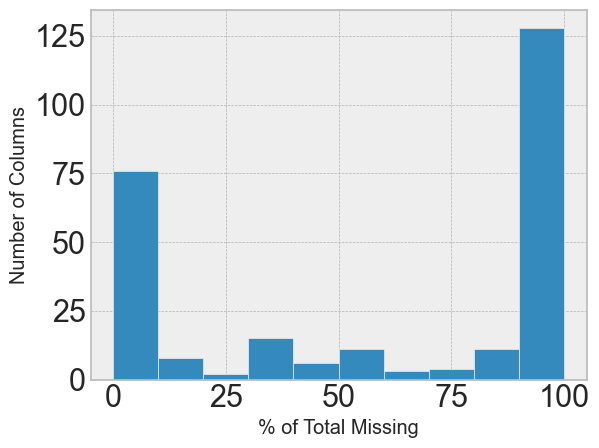

In [10]:
fig = plt.figure()
missing_data_table['% of Total'].hist()
plt.xlabel('% of Total Missing')
plt.ylabel('Number of Columns')

In [11]:
# Filter out columns that have >50% missing data

columns_to_drop = list(missing_data_table[ missing_data_table['% of Total'] > 50 ].index)

data = data.drop(columns=columns_to_drop)
print("Dataframe shape after dropping columns:", data.shape)

Dataframe shape after dropping columns: (64169, 107)


# Exploratory Data Analysis

The next portion of the script will focus on Exploratory Data Analysis (EDA), which refers to the process of making plots and calculations on the data to learn more about its constituent features and data patterns. The purpose of EDA is to find anomalies, trends, or relationships which may be useful when informing modeling decisions downstream. EDA typically begins with a high-level overview and gradually narrows in on more specific features of the dataset. 

We'll start EDA by exploring the Energy Star Score (hereon refered to as just 'score'), which is the target variable for our machine learning model. We'll start with a simple distribution of scores in our dataset.

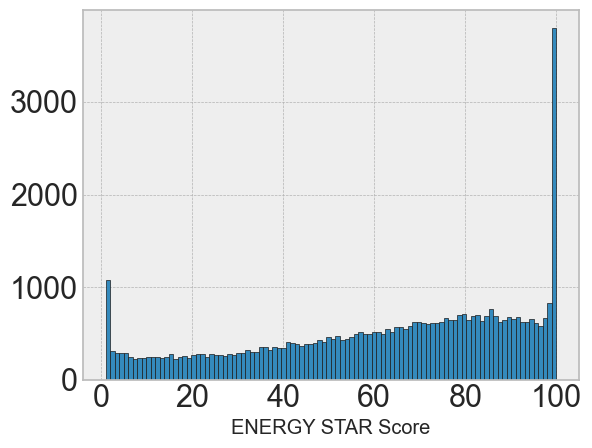

In [12]:
fig = plt.figure()
plt.hist(data['ENERGY STAR Score'].dropna(),bins=100, edgecolor='k')
plt.xlabel("ENERGY STAR Score")
plt.xticks(np.arange(0, 101, 20),np.arange(0, 101, 20));

It's peculiar that there are strong peaks at scores of 0 and 100. We would expect this distribution to e fairly flatflat which given that energy star scores are equivalent to percentile ranks, according to the official definition (linked [here](https://data.cityofnewyork.us/Environment/NYC-Building-Energy-and-Water-Data-Disclosure-for-/5zyy-y8am/about_data)). The score is based on information provided by applicable property owners to the city. One of these factors is the Site EUI (energy usage intensity), which measures energy usage per square foot. The sharp peak at 100 may indicate some property owners are over-estimating their star score rating, which is self-reported. The peak at 0 is perhaps due to default values set by the software used by property owners to estimate their scores.

In [13]:
print("\nSummary stats:\n", data['Site EUI (kBtu/ft²)'].describe())
print("\nLargest values:\n", data['Site EUI (kBtu/ft²)'].dropna().sort_values().tail(10))

data.loc[data['Site EUI (kBtu/ft²)']==869265, :]



Summary stats:
 count    5.977800e+04
mean     7.964434e+03
std      2.327075e+05
min     -4.000000e-01
25%      5.160000e+01
50%      7.240000e+01
75%      9.350000e+01
max      1.493100e+07
Name: Site EUI (kBtu/ft²), dtype: float64

Largest values:
 Property ID
10855948    10078420.0
33602969    10127000.0
33898146    10599000.0
33602833    10924100.0
10856048    11082470.0
4038923     12514460.0
4038925     12866090.0
25764297    13417900.0
25764297    14708000.0
4038924     14931000.0
Name: Site EUI (kBtu/ft²), dtype: float64


,Calendar Year,Property Name,Parent Property ID,Parent Property Name,Year Ending,"NYC Borough, Block and Lot (BBL)",NYC Building Identification Number (BIN),Address 1,City,Postal Code,Primary Property Type - Self Selected,Primary Property Type - Portfolio Manager-Calculated,National Median Reference Property Type,List of All Property Use Types (GFA) (ft²),Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Construction Status,Number of Buildings,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,National Median ENERGY STAR Score,Eligible for Certification for Report PED (Y/N),Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),National Median Site EUI (kBtu/ft²),Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),...,Multifamily Housing - Total Number of Residential Living Units,"Multifamily Housing - Total Number of Residential Living Units Density (Number per 1,000 sq ft)","Multifamily Housing - Number of Residential Living Units in a High-Rise Building Density (Number per 1,000 sq ft)",Multifamily Housing - Number of Residential Living Units in a Mid-Rise Building (5-9 Stories),"Multifamily Housing - Number of Residential Living Units in a Mid-Rise Building Density (Number per 1,000 sq ft)",Property GFA - Self-Reported (ft²),Property GFA - Calculated (Buildings and Parking) (ft²),Property GFA - Calculated (Buildings) (ft²),Water Use (All Water Sources) (kgal),Indoor Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Total Use (All Meter Types) (kgal),Municipally Supplied Potable Water - Indoor Use (kgal),Data Quality Checker Run?,Electric Distribution Utility,Number of Active Energy Meters - Total,Number of Active Energy Meters - Used to Compute Metrics,Number of Active Energy Meters - Not Used to Compute Metrics,Number of Active IT Meters,Aggregate Meter(s)-Electric – Number of Individual Meters Included,Aggregate Meter(s)-Natural Gas – Number of Individual Meters Included,Aggregate Meter(s)-District Steam – Number of Individual Meters Included,Report Generation Date,Report Submission Date,Borough,Latitude,Longitude,Community Board,Council District,Census Tract (2020),Neighborhood Tabulation Area (NTA) (2020)
Property ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Upon the first iteration of plotting Site EUI, I produced a histogram that was uninterpretable due to an extreme outlier. To investigate the outlier, I printed the summary stats above and printed the largest values in the 'Site EUI' column. I found one row with the value `869,265.0` while all others were `< 150,000`. Since there was only one outlier in a database with nearly 12,000 rows, I decided to drop this outlier. This was done using the IQR method in the next cell, followed by the final distribution of Site EUI.

In [14]:
# Remove outlier with IQR
first_quartile = data['Site EUI (kBtu/ft²)'].quantile(0.25)
third_quartile = data['Site EUI (kBtu/ft²)'].quantile(0.75)

# IQR (interquartile range)
iqr = third_quartile - first_quartile

# outliers are either below (0.25 - 3IQR) or above (0.75 + 3IQR)
data = data[
    (data['Site EUI (kBtu/ft²)'] > (first_quartile - 3 * iqr)) & 
    (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3 * iqr))
]

Text(0.5, 1.0, 'Site EUI (kBtu/ft²)')

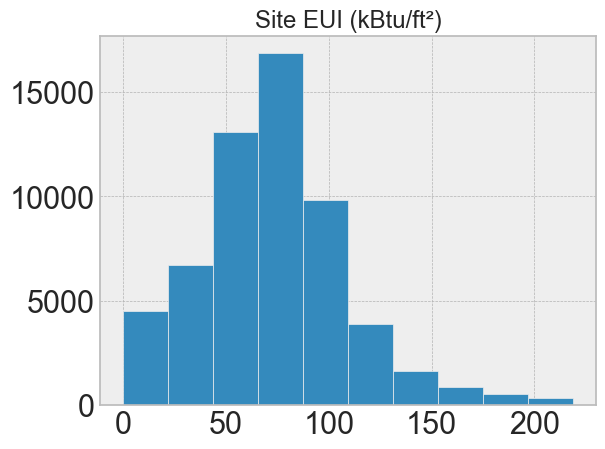

In [15]:
fig = plt.figure()
n_bins = 100
min = data['Site EUI (kBtu/ft²)'].min()
max = data['Site EUI (kBtu/ft²)'].quantile(0.75)
width = (max-min)/n_bins

bins = np.arange(min, max, width)

plt.hist(data['Site EUI (kBtu/ft²)'])
plt.title('Site EUI (kBtu/ft²)')

This distribution appears Gaussian with a positive skew (long tail on the right). The sharp peaks observed in the score distribution do not reappear in this figure.

In [16]:
# explore unique values in the column that indicates property type
column_name = 'Largest Property Use Type'
property_types = list(data[column_name].unique())

print(f"\n\n{column_name}:", data[column_name].unique())
print(f"\nDataset contains {data[column_name].nunique()} unique property types from column `{column_name}`.")



Largest Property Use Type: ['Non-Refrigerated Warehouse' 'Multifamily Housing' 'Office'
 'Medical Office' 'Enclosed Mall' 'Worship Facility' 'Hotel'
 'Manufacturing/Industrial Plant' 'Residence Hall/Dormitory'
 'Retail Store' 'Self-Storage Facility' 'Performing Arts'
 'Refrigerated Warehouse' 'Supermarket/Grocery Store' 'K-12 School'
 'Repair Services (Vehicle, Shoe, Locksmith, etc.)' 'Distribution Center'
 'Laboratory' 'Parking' 'Outpatient Rehabilitation/Physical Therapy'
 'Hospital (General Medical & Surgical)' 'Residential Care Facility'
 'Other' 'Transportation Terminal/Station' 'Financial Office'
 'Bank Branch' 'Other - Lodging/Residential' 'Bowling Alley'
 'Senior Living Community' 'Adult Education' 'Strip Mall'
 'College/University' 'Fitness Center/Health Club/Gym'
 'Automobile Dealership' 'Pre-school/Daycare' 'Other - Recreation'
 'Restaurant' 'Food Service' 'Movie Theater' 'Mailing Center/Post Office'
 'Single-Family Home' 'Library' 'Police Station' 'Stadium (Open)'
 'Socia

In [17]:
# explore unique values in the column that indicates property type
column_name = 'Primary Property Type - Self Selected'
property_types = list(data[column_name].unique())

print(f"\n\n{column_name}:", data[column_name].unique())
print(f"\nDataset contains {data[column_name].nunique()} unique property types from column `{column_name}`.")



Primary Property Type - Self Selected: ['Non-Refrigerated Warehouse' 'Multifamily Housing' 'Mixed Use Property'
 'Medical Office' 'Office' 'Enclosed Mall' 'Worship Facility' 'Hotel'
 'Manufacturing/Industrial Plant' 'Residence Hall/Dormitory'
 'Retail Store' 'Self-Storage Facility' 'Performing Arts'
 'Refrigerated Warehouse' 'Supermarket/Grocery Store' 'K-12 School'
 'Repair Services (Vehicle, Shoe, Locksmith, etc.)' 'Distribution Center'
 'Laboratory' 'Parking' 'Outpatient Rehabilitation/Physical Therapy'
 'Hospital (General Medical & Surgical)' 'Residential Care Facility'
 'Transportation Terminal/Station' 'Financial Office' 'Bank Branch'
 'Other - Lodging/Residential' 'Bowling Alley' 'Senior Living Community'
 'Adult Education' 'Strip Mall' 'College/University'
 'Fitness Center/Health Club/Gym' 'Automobile Dealership'
 'Pre-school/Daycare' 'Other - Recreation' 'Food Service' 'Movie Theater'
 'Mailing Center/Post Office' 'Other' 'Library' 'Police Station'
 'Stadium (Open)' 'Social/

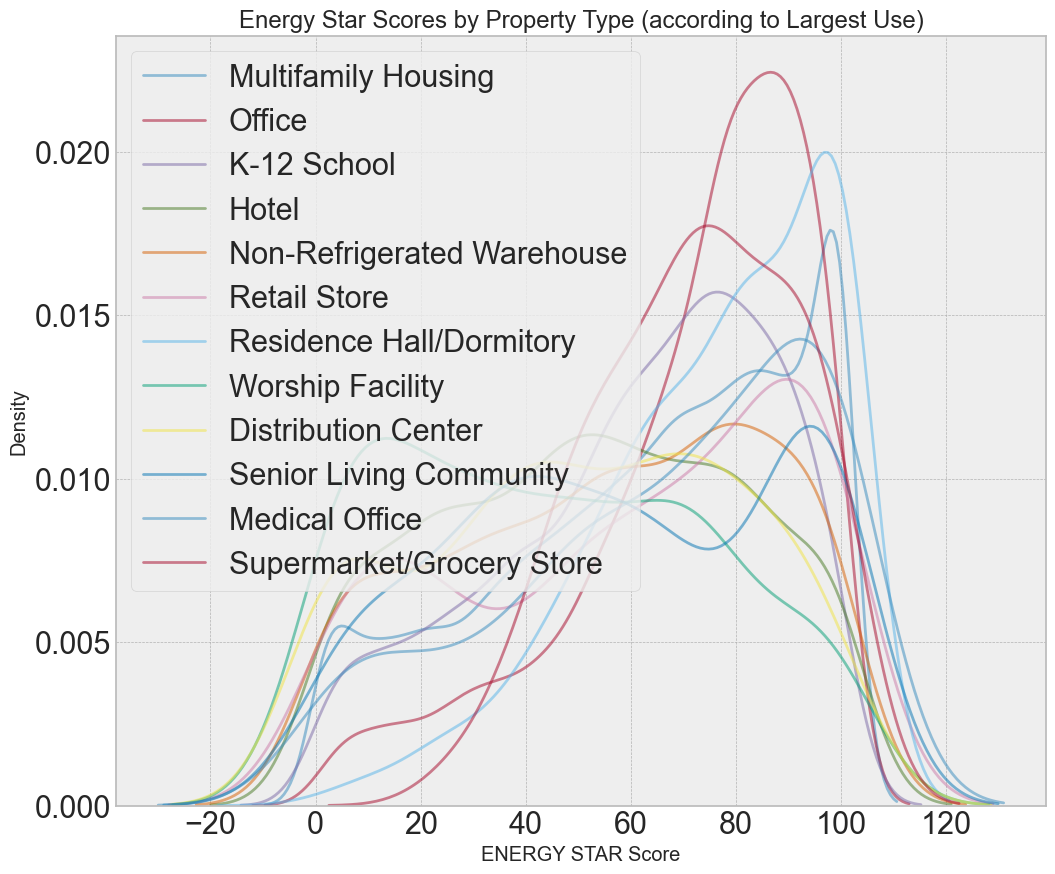

In [18]:
# Plot distribution of Site EUI based on property type in 'largest use' column

# set designated column for determining property type
column_name = 'Largest Property Use Type'

# drop rows with missing score values
data_with_scores = data.dropna(subset=['ENERGY STAR Score'])
property_counts = data_with_scores[column_name].value_counts()
property_types = list(property_counts[property_counts.values > 100].index)

# initiate new figure
fig = plt.figure(figsize=(12,10))

# iterate through property types
for each_type in property_types:
    # filter out relevant rows
    subset = data[data[column_name] == each_type ]
    
    # add to density plot
    sns.kdeplot(
        subset['ENERGY STAR Score'].dropna(),
        label = each_type,
        fill = False,
        alpha = 0.5
        )
plt.legend()
plt.title("Energy Star Scores by Property Type (according to Largest Use)");

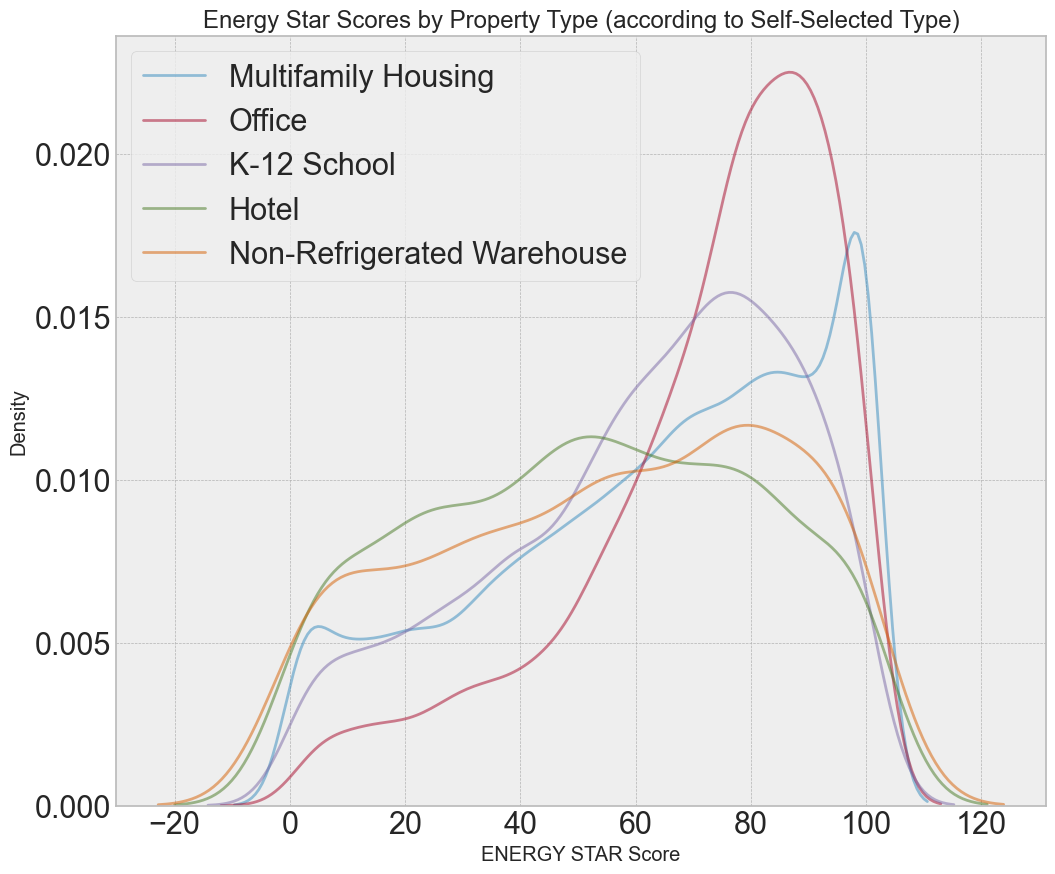

In [19]:
# Plot distribution of Site EUI based on property type in 'largest use' column

# set designated column for determining property type
column_name = 'Primary Property Type - Self Selected'

# drop rows with missing score values
data_with_scores = data.dropna(subset=['ENERGY STAR Score'])
property_counts = data_with_scores[column_name].value_counts()
property_types = list(property_counts[property_counts.values > 100].index)

# initiate new figure
fig = plt.figure(figsize=(12,10))

# iterate through property types
for each_type in property_types[0:5]:
    # filter out relevant rows
    subset = data[data[column_name] == each_type ]
    
    # add to density plot
    sns.kdeplot(
        subset['ENERGY STAR Score'].dropna(),
        label = each_type,
        fill = False,
        alpha = 0.5
        )
plt.legend()
plt.title("Energy Star Scores by Property Type (according to Self-Selected Type)");

The figures above agree well with each other, which is a good sanity check to see that the two categorical columns indicating property type agree well with one another. Since property type does have a role in the star score distribution, we should feed it into the machine learning model (after one-hot encoding). 

In addition to property types, there are other categorical columns such as the borough.


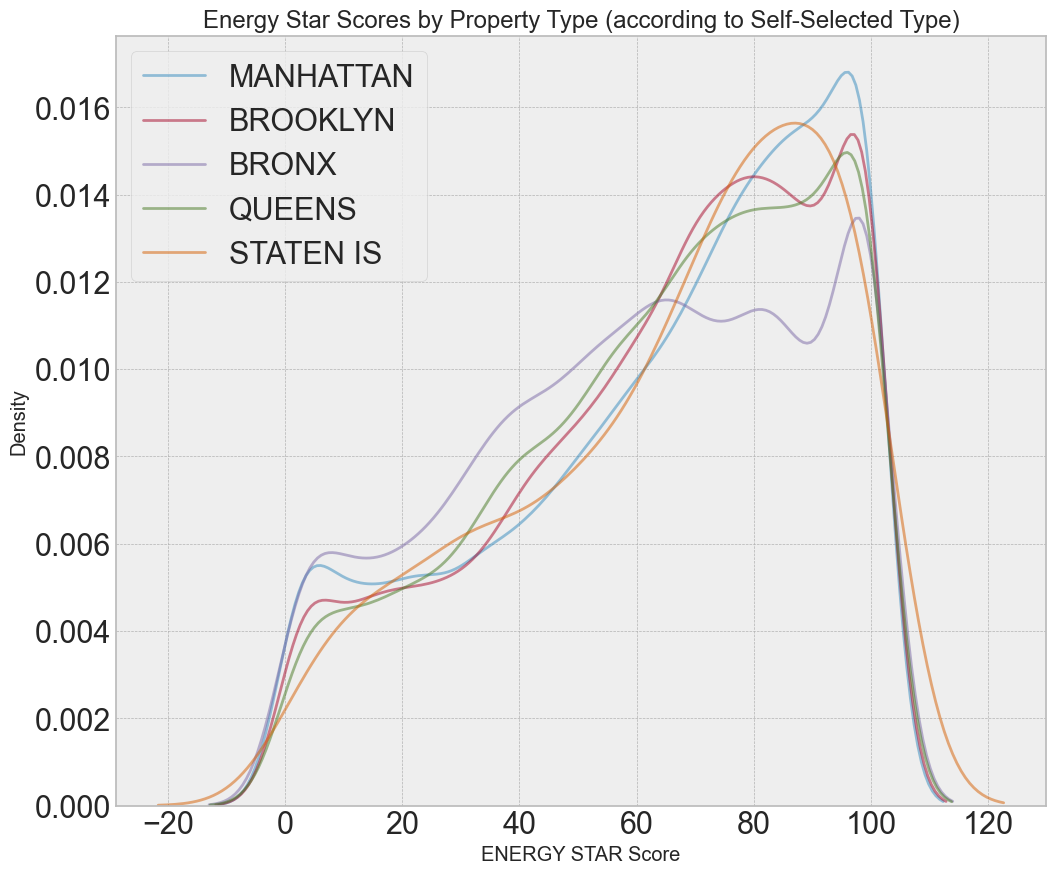

In [20]:
# Plot distribution of Site EUI based on borough

# set designated column for determining property type
column_name = 'Borough'

# drop rows with missing score values
data_with_scores = data.dropna(subset=['ENERGY STAR Score'])
borough_counts = data_with_scores[column_name].value_counts()
borough_types = list(borough_counts[borough_counts.values > 100].index)

# initiate new figure
fig = plt.figure(figsize=(12,10))

# iterate through property types
for each_type in borough_types[0:5]:
    # filter out relevant rows
    subset = data[data[column_name] == each_type ]
    
    # add to density plot
    sns.kdeplot(
        subset['ENERGY STAR Score'].dropna(),
        label = each_type,
        fill = False,
        alpha = 0.5
        )
plt.legend()
plt.title("Energy Star Scores by Property Type (according to Self-Selected Type)");

The borough of the building does not seem to make as significant a difference in the distribution of the score as does the building type. Nonetheless, it might make sense to include the borough as a categorical variable. 

One final density plot we can make is to break out 

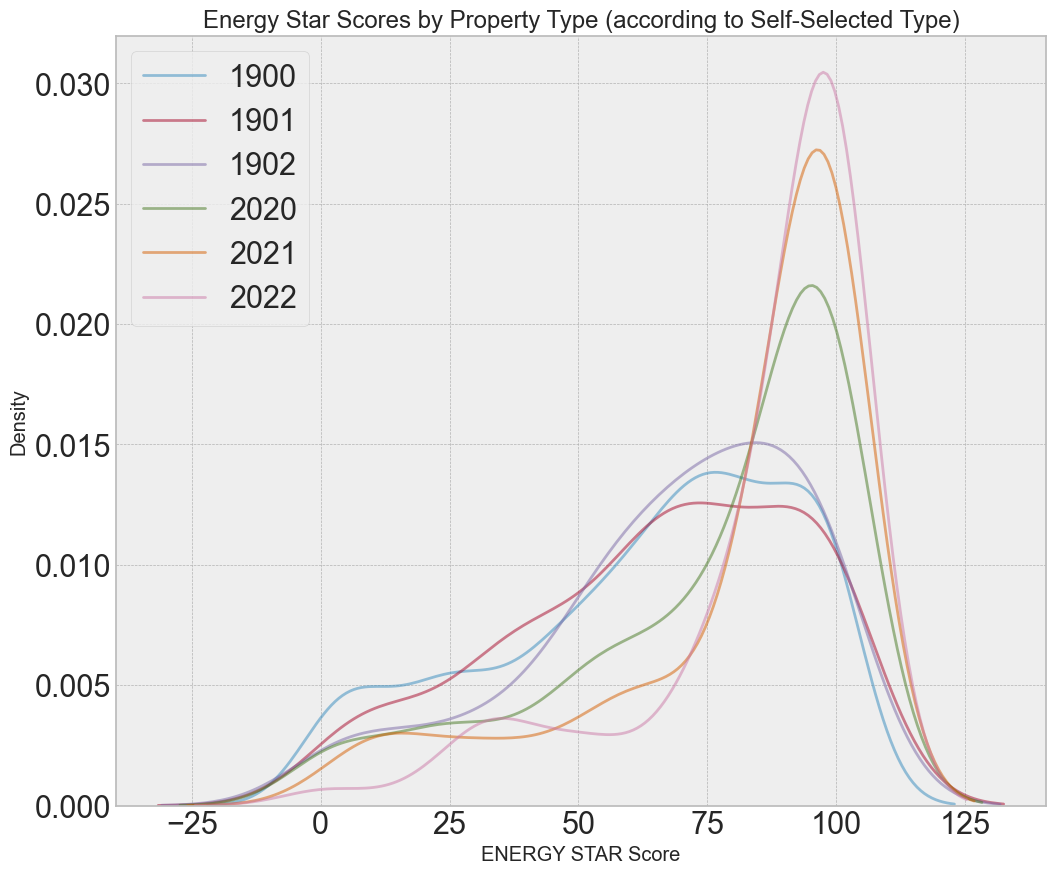

In [21]:
# Plot distribution of Site EUI based on year build

# set designated column for determining property type
column_name = 'Year Built'

# drop rows with missing score values
data_with_scores = data.dropna(subset=['ENERGY STAR Score'])
cat_counts = data_with_scores[column_name].value_counts()
cat_types = list(cat_counts[cat_counts.values > 100].index)
cat_types.sort()

# initiate new figure
fig = plt.figure(figsize=(12,10))

# iterate through property types
for each_type in (cat_types[0:3] +  cat_types[-3:]):
    # filter out relevant rows
    subset = data[data[column_name] == each_type ]
    
    # add to density plot
    sns.kdeplot(
        subset['ENERGY STAR Score'].dropna(),
        label = each_type,
        fill = False,
        alpha = 0.5,
        )
    
plt.legend()
plt.title("Energy Star Scores by Property Type (according to Self-Selected Type)");

Thankfully, it appears that older buildings tend to have a stronger peak at higher energy scores. This could also be related to correlations between the property type and building year. For example, 1970 seems to be a very good year for building efficient properties in terms of energy star scores. Its distribution however looks similar to that of office buildings and Manhattan buildings, so perhaps it isn't necessarily that buildings from 1970 are more energy-efficient, but that a high fraction of offices, which tend to be energy-efficient, were built in 1970. 

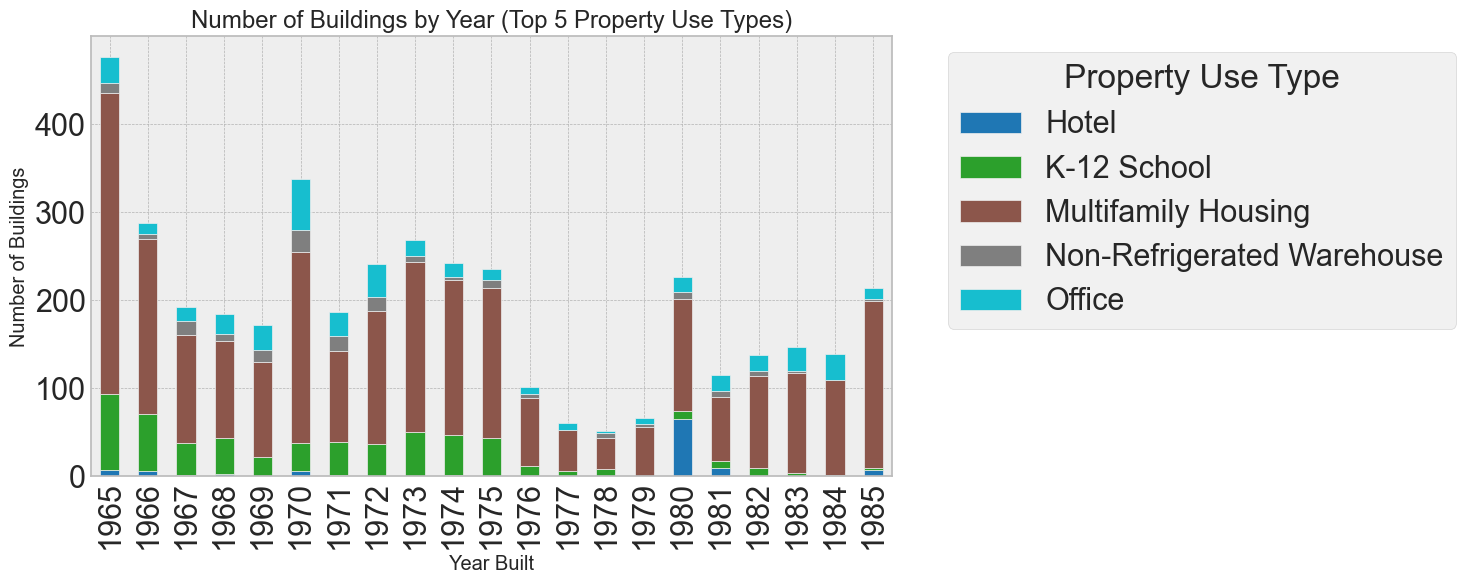

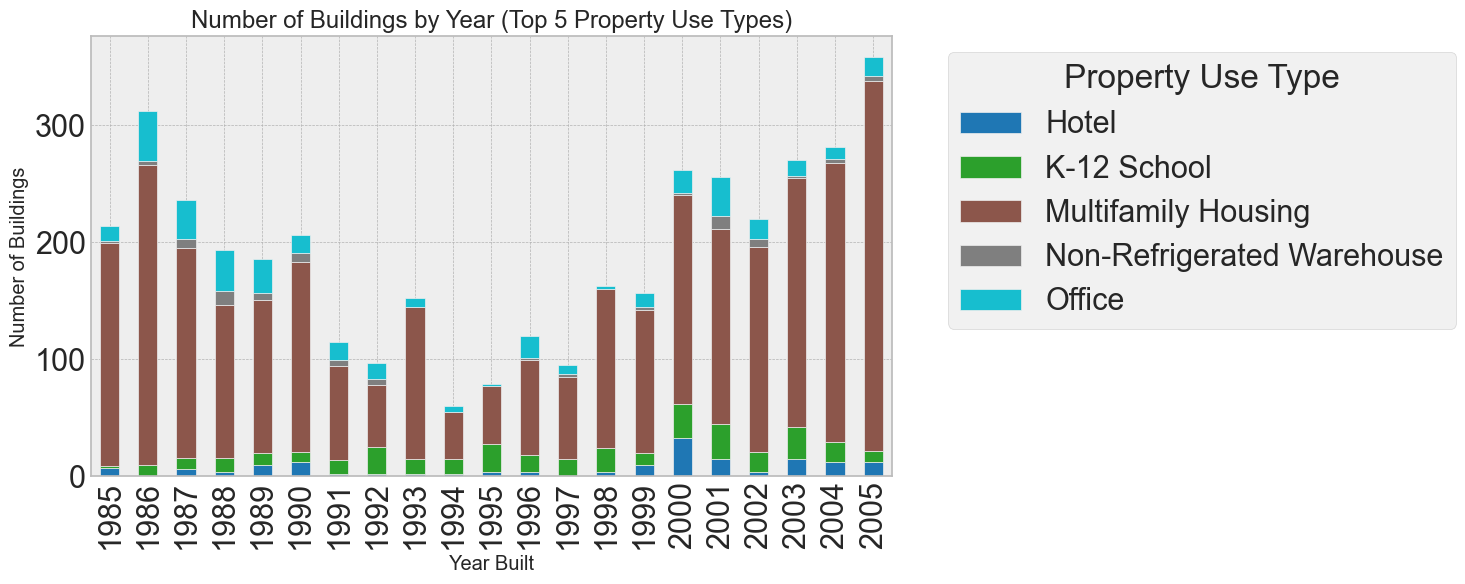

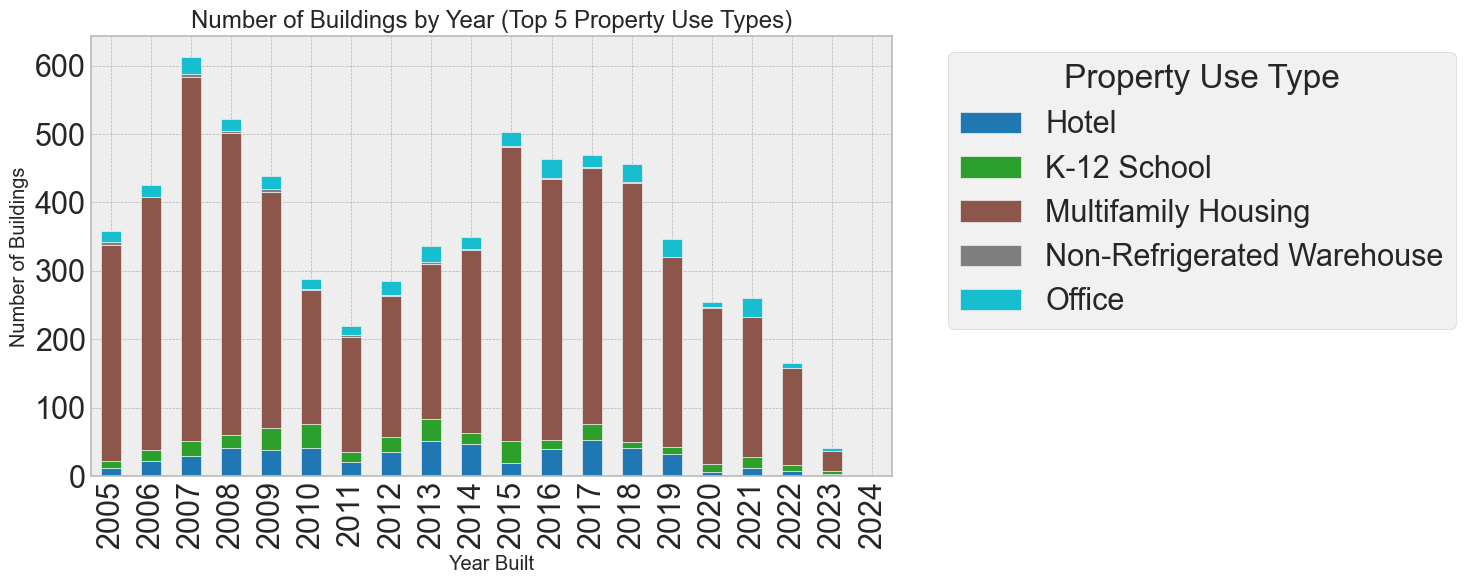

In [22]:
year_ranges = [ 
    [1965, 1985],
    [1985, 2005],
    [2005, 2025]
]

for each_range in year_ranges:
    # Step 1: Get top 5 most common property use types
    top5_types = data['Largest Property Use Type'].value_counts().nlargest(5).index

    # Step 2: Filter to only those 5 types
    filtered_data = data[
        (data['Largest Property Use Type'].isin(top5_types)) &
        (data['Year Built'].between(each_range[0], each_range[1]))
    ]

    # Step 3: Create pivot table: rows=Year Built, columns=Property Type, values=counts
    pivot_table = (
        filtered_data
        .groupby(['Year Built', 'Largest Property Use Type'])
        .size()
        .unstack(fill_value=0)
        .sort_index()
    )

    # Step 4: Plot stacked bar chart
    pivot_table.plot(kind='bar', stacked=True, figsize=(15, 6), colormap='tab10')

    plt.title("Number of Buildings by Year (Top 5 Property Use Types)")
    plt.xlabel("Year Built")
    plt.ylabel("Number of Buildings")
    plt.legend(title='Property Use Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


We see that there are more offices built in 1970 relative to most other years (especially more recent years). We also see a sharp peak in the total buildings constructed in that year. We also see trends in construction over time. Here are some summary bullet points about the stacked bar plots above:

- Construction of buildings was relatively constant from 1965 to 1985, with the exception of increased buildings in 1965, 1970, and 1985.
- The majority of new bulidings that are put up every year are multi-family housing.
- A higher fraction of new buildings were office bulidings in 1970.
- There was a steady decline in construction rates from 1986 to 1998.


# Correlation Studies

We can search for correlations between features using the Pearson correlation coefficient. 

['Water Use (All Water Sources) (kgal)', 'Municipally Supplied Potable Water - Total Use (All Meter Types) (kgal)', 'Indoor Water Use (All Water Sources) (kgal)', 'Municipally Supplied Potable Water - Indoor Use (kgal)', 'Electricity Use - Grid Purchase (kBtu)', 'Electricity Use - Grid Purchase (kWh)']


<Axes: >

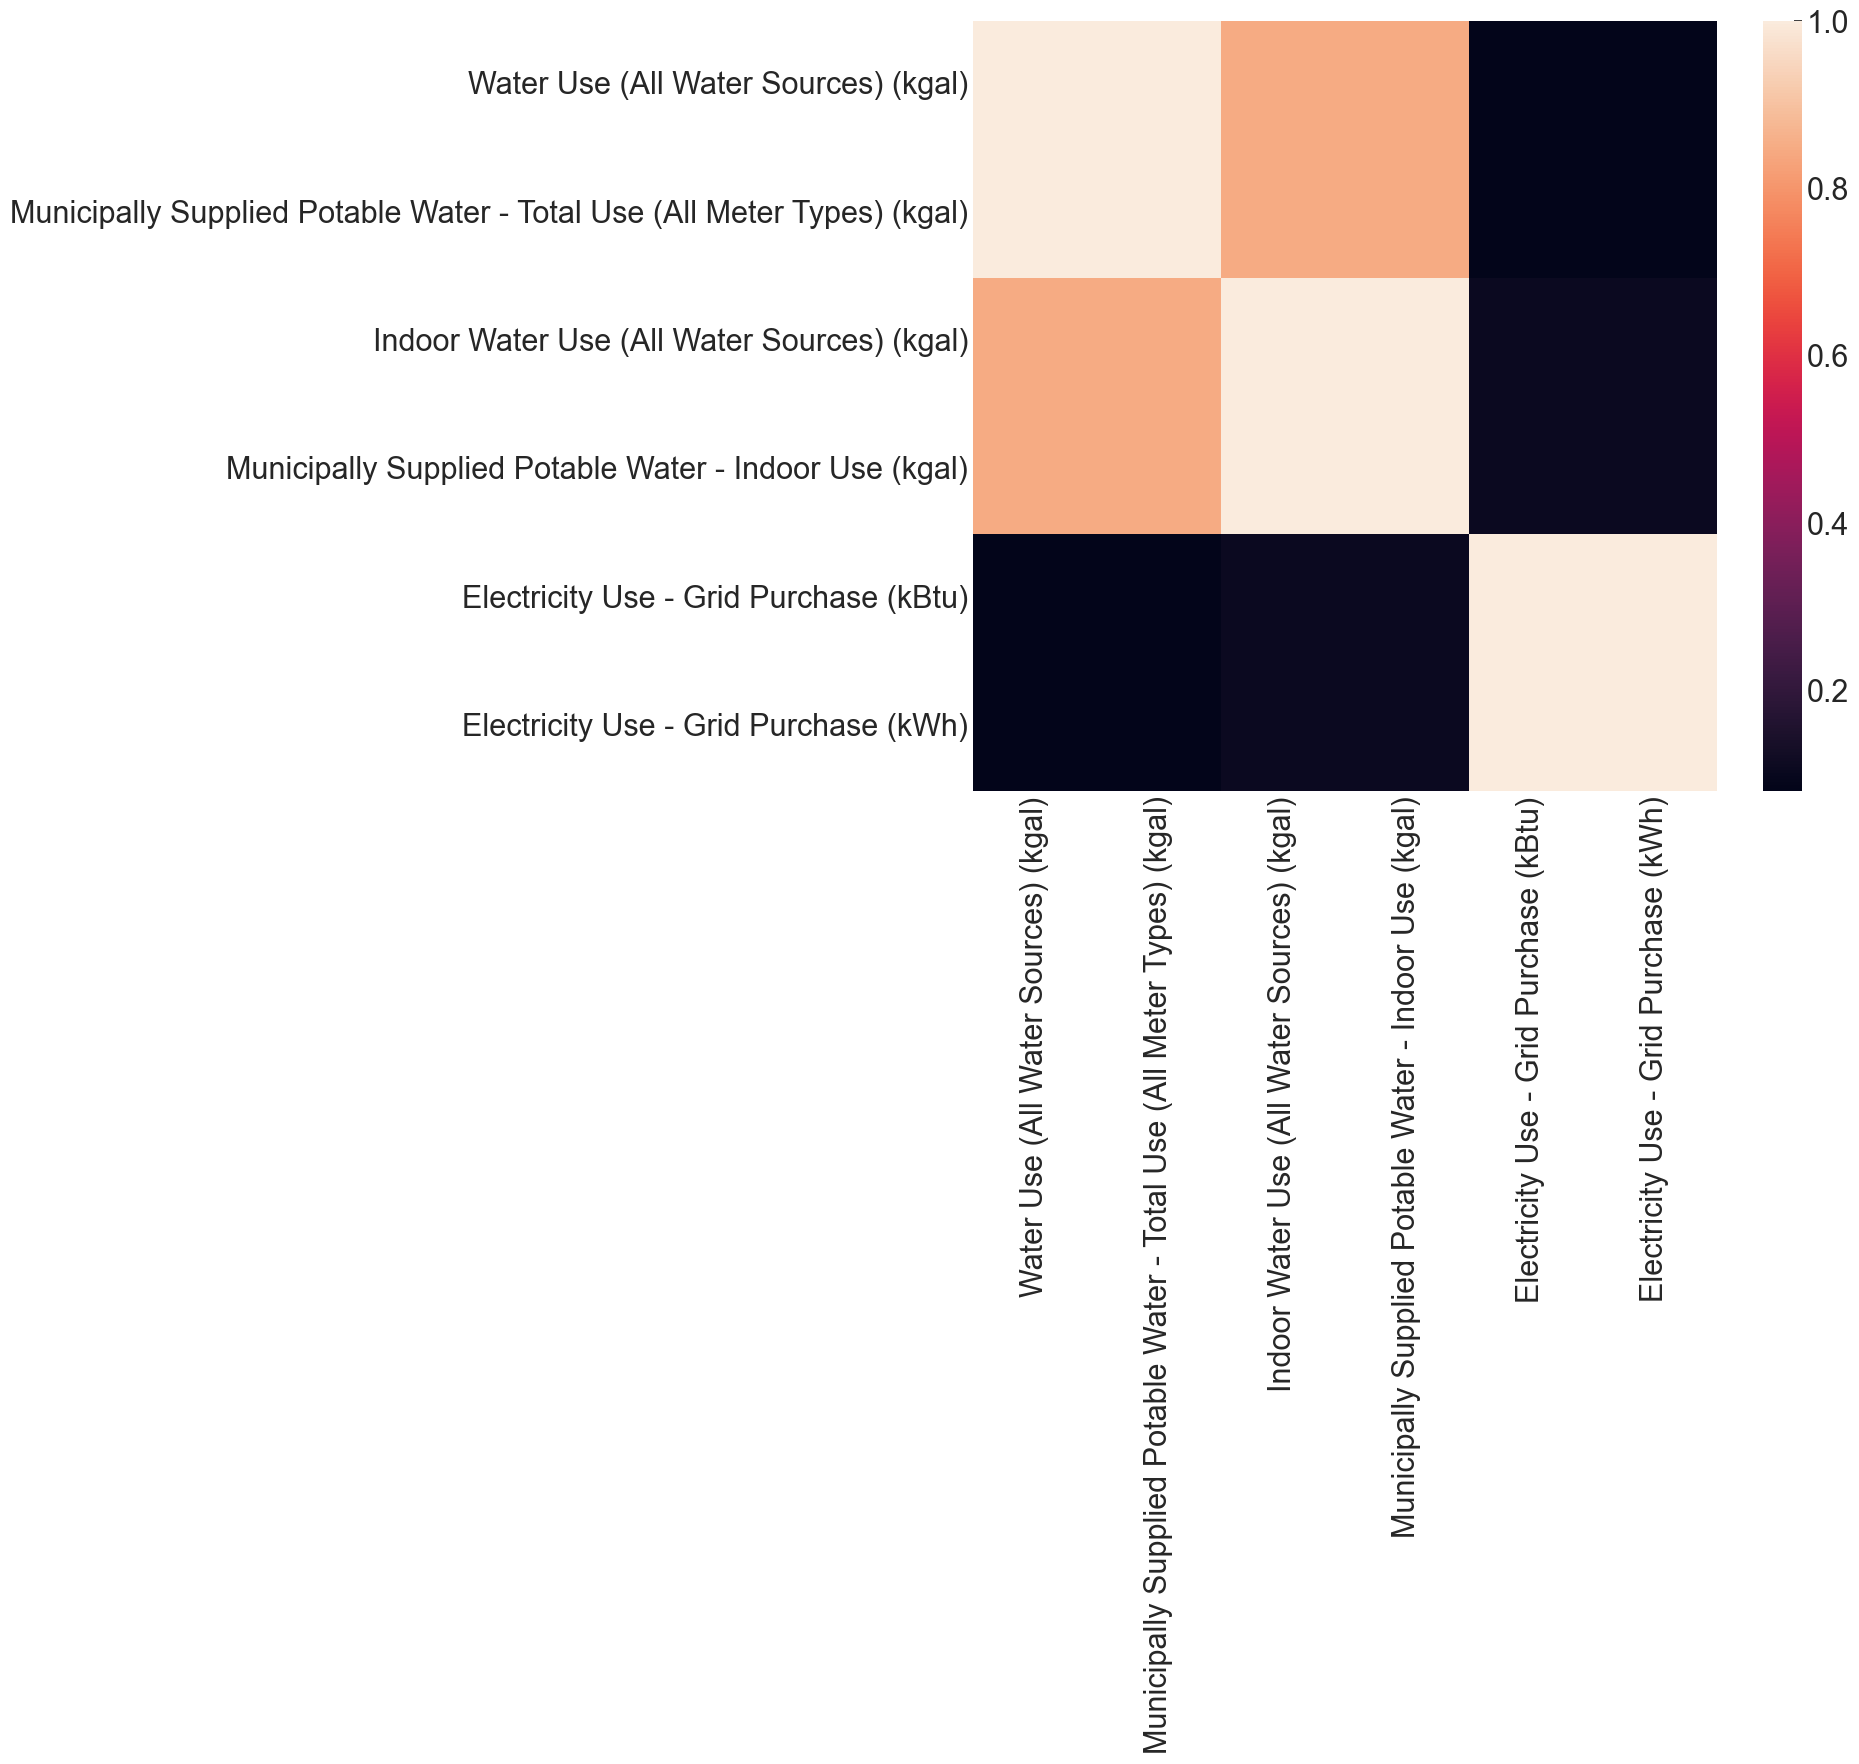

In [36]:
numeric_data = data.select_dtypes(include=[np.number]).dropna()
correlation_matrix = numeric_data.corr()
correlation_series = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)).stack()


top_correlations = correlation_series.nlargest(3)
top_features = correlation_series.abs().sort_values(ascending=False).head(3).index.tolist()

columns_to_keep = []
for each_pair in top_features:
    if each_pair[0] not in columns_to_keep:
        columns_to_keep.append(each_pair[0])
    if each_pair[1] not in columns_to_keep:
        columns_to_keep.append(each_pair[1])

print((columns_to_keep))
high_corr_data = data[columns_to_keep]
sns.heatmap(high_corr_data.corr())


The correlation matrix above allows shows that many columns have a nearly-equivalent partner column. Moreover, there are two versions of many of the figures, one for `Source` and another for `Site`. For example, EUI is split into `Source EUI` and `Site EUI`. Based on this [document](https://www.nyc.gov/html/gbee/downloads/pdf/nyc_ll84_benchmarking_report_2012.pdf), source energy usage figures refer to the total energy needed to create the consumption levels on-site. Site energy usage does not take into account energy generation or losses and is thus a less comprehensive estimate of a property's total energy cost. In addition to site vs source energy usage, the correlation matrix shows us that energy usage columns are also partnered with a weather-normalized column, which exhibit nearly identical correlation coefficients. This is why the 6x6 matrix apears more like a 3x3.

Now let's investigate the correlation between numeric columns and the energy score. 

In [24]:
correlations_data = numeric_data.corr()['ENERGY STAR Score'].sort_values()
print(correlations_data)

Site EUI (kBtu/ft²)                                                                                                -0.741755
Weather Normalized Site EUI (kBtu/ft²)                                                                             -0.739216
Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)                                                        -0.726831
Weather Normalized Source EUI (kBtu/ft²)                                                                           -0.721243
Source EUI (kBtu/ft²)                                                                                              -0.707618
                                                                                                                      ...   
Multifamily Housing - Number of Residential Living Units in a Mid-Rise Building Density (Number per 1,000 sq ft)    0.123148
ENERGY STAR Score                                                                                                   1.000000


The strongest correlations occur between site EUI and source EUI. These correlations are negative, meaning that a higher EUI value is associated with a lower energy score. This makes sense, as a higher EUI is equivalent to a higher energy consumption per square footage. As we discovered in the previous correlation plot, site vs. source figures have similar correlation coefficients, suggesting that there is a linear relationship between site energy consumption and source energy consumption. We can pick only one of the two measurement standards for analysis.

To account for possible non-linear relationships, we can take square root and natural log transformations of the features and then calculate the correlation coefficients with the score. These transformations would transform exponential or quadratic relationships to a more linear form. To try and capture any possible relationships between the borough or building type (remember these are categorical variables) and the score we will have to one-hot encode these columns.


In [25]:
# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'ENERGY STAR Score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Drop buildings without an energy star score
features = features.dropna(subset = ['ENERGY STAR Score'])

# Find correlations with the score 
correlations = features.corr()['ENERGY STAR Score'].dropna().sort_values()

/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/a

In [26]:
# Display most negative correlations
correlations.head(15)

Site EUI (kBtu/ft²)                                                -0.741755
Weather Normalized Site EUI (kBtu/ft²)                             -0.739216
sqrt_Weather Normalized Source EUI (kBtu/ft²)                      -0.732143
Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)        -0.726831
sqrt_Source EUI (kBtu/ft²)                                         -0.723430
sqrt_Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)   -0.722967
sqrt_Site EUI (kBtu/ft²)                                           -0.721300
Weather Normalized Source EUI (kBtu/ft²)                           -0.721243
sqrt_Weather Normalized Site EUI (kBtu/ft²)                        -0.716978
Source EUI (kBtu/ft²)                                              -0.707618
log_Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)    -0.665287
log_Weather Normalized Source EUI (kBtu/ft²)                       -0.636518
log_Source EUI (kBtu/ft²)                                          -0.634517

In [27]:
# Display most positive correlations
correlations.tail(15)

log_National Median Total (Location-Based) GHG Emissions (Metric Tons CO2e)                                              0.079372
log_Multifamily Housing - Number of Bedrooms Density (Number per 1,000 sq ft)                                            0.083013
sqrt_Multifamily Housing - Number of Bedrooms Density (Number per 1,000 sq ft)                                           0.087477
Largest Property Use Type_Office                                                                                         0.094666
log_Green Power - Offsite (kWh)                                                                                          0.098471
log_Multifamily Housing - Number of Residential Living Units in a Mid-Rise Building (5-9 Stories)                        0.107354
log_Avoided Emissions - Offsite Green Power (Metric Tons CO2e)                                                           0.108411
National Median Source EUI (kBtu/ft²)                                                     

Even after data transformations, Site UI is still the most strong negatively-correlated feature to energy scores. There are no strong positive linear relationships although we do see that a building type of office (`Largest Property Use Type_Office`) is slightly positively correlated with the score. This variable is a one-hot encoded representation of the categorical variables for building type. To visualize the correlation between energy scores and site EUI, we can make a scatter plot. We'll use different colors to distinguish different property types. 

Text(0.5, 1.0, 'Energy Star Score vs Site EUI')

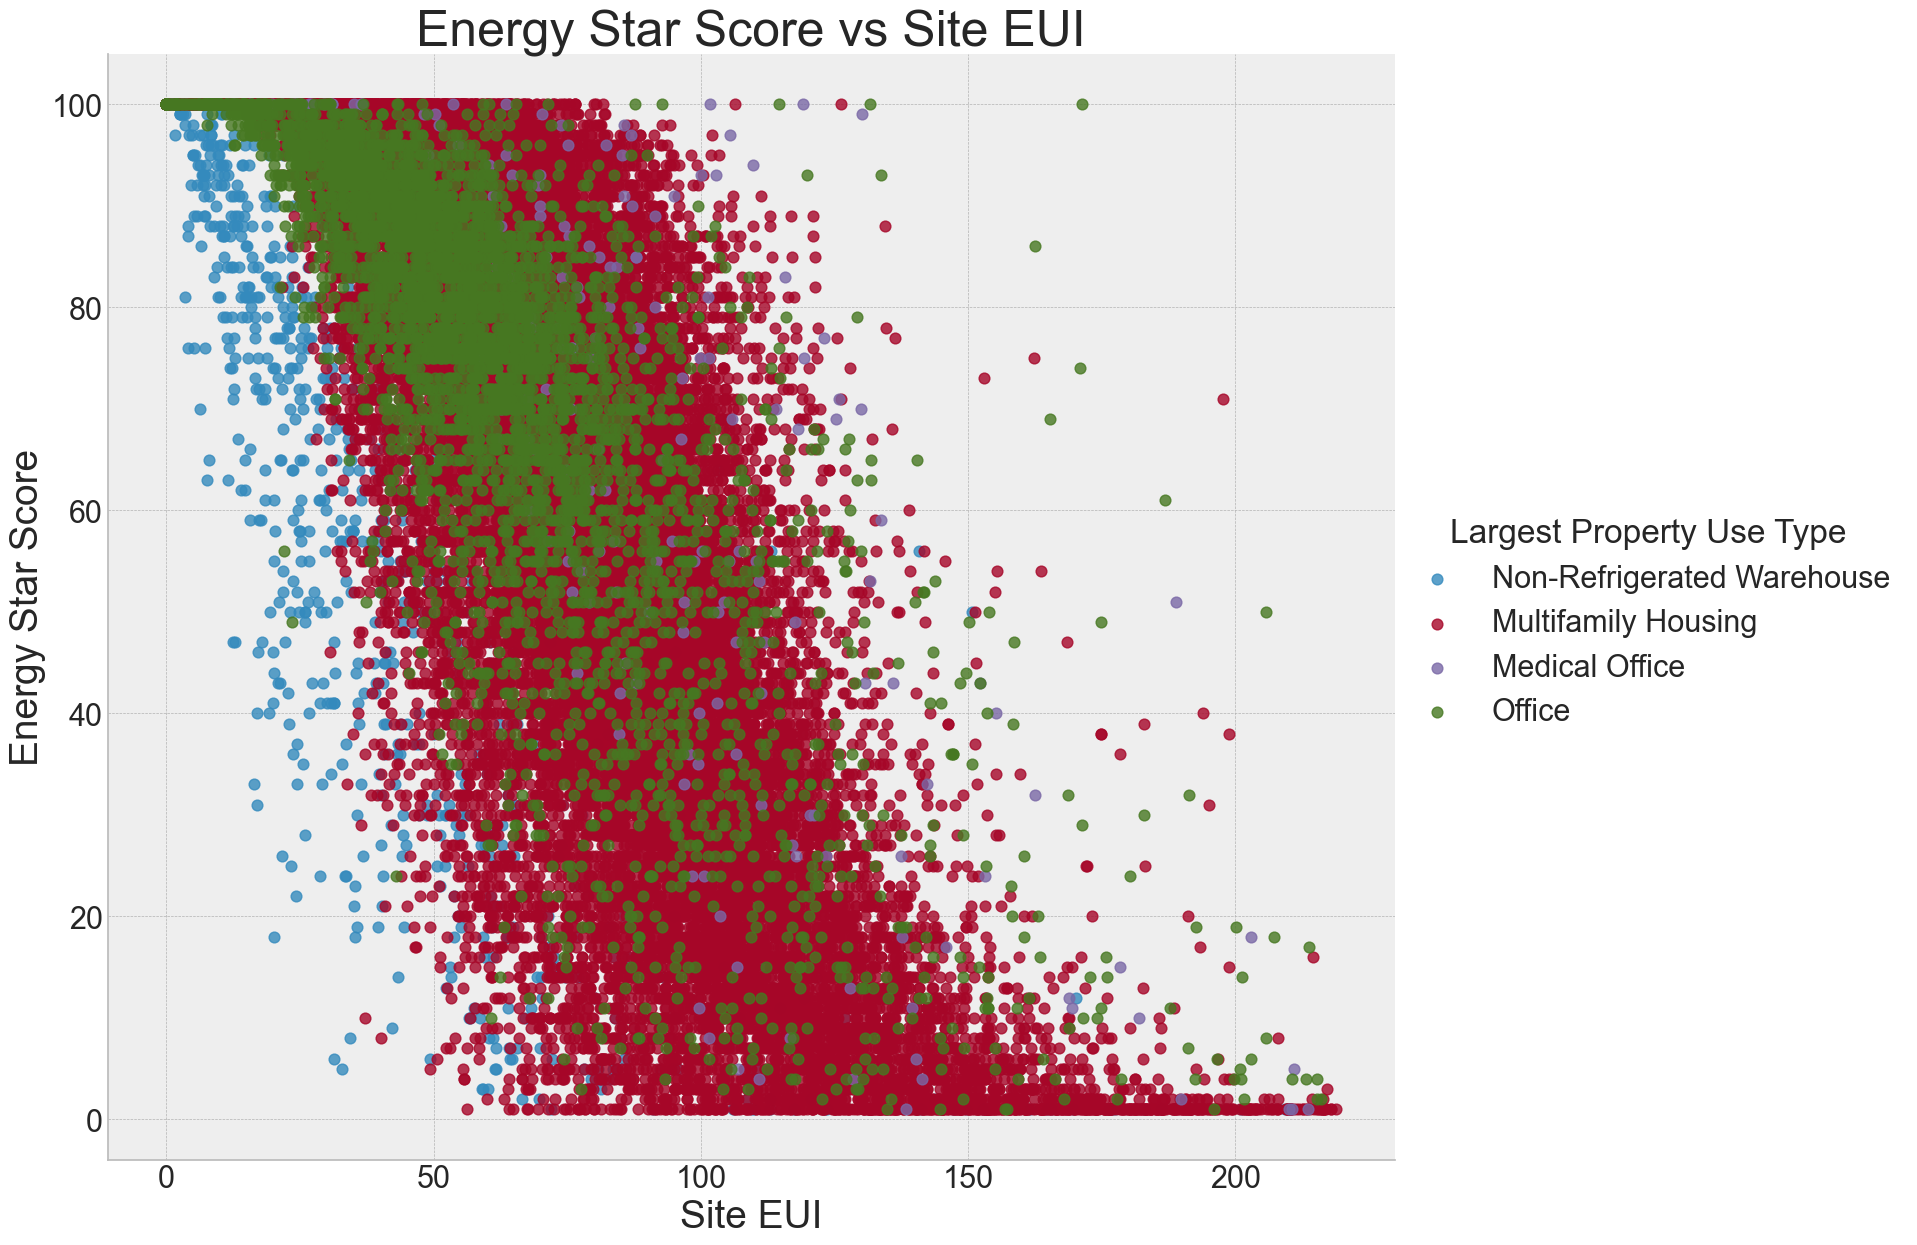

In [28]:
from IPython.core.pylabtools import figsize

column_name = 'Largest Property Use Type'
property_types = list(data[column_name].unique()[0:5])

# Set figure size
figsize(12, 10)

# Extract building types for rows where 'score' is not NaN
features['Largest Property Use Type'] = data.dropna(subset=['ENERGY STAR Score'])['Largest Property Use Type']

# Filter to building types with more than 100 observations
features = features[features['Largest Property Use Type'].isin(property_types)]

# Create the scatterplot using seaborn
sns.lmplot(
    data=features,
    x='Site EUI (kBtu/ft²)',
    y='ENERGY STAR Score',
    hue='Largest Property Use Type',
    scatter_kws={'alpha': 0.8, 's': 60},
    fit_reg=False,
    height=12,
    aspect=1.2
)

# Customize labels and title
plt.xlabel("Site EUI", fontsize=28)
plt.ylabel("Energy Star Score", fontsize=28)
plt.title("Energy Star Score vs Site EUI", fontsize=36)


This plot confirms the relationship we saw in the correlation coefficient: the energy score is inversely related to the site EUI. Though the relationship doesn't look linear, the site EUI will be important for predicting energy scores in unseen data.

As a final exercise for exploratory data analysis, we can make a pairs plot between several different variables. Pairs plots are scatter plots between pairs of variables and histograms of single variables on the diagonal. 

Text(0.5, 1.02, 'Pairs Plot of Energy Data')

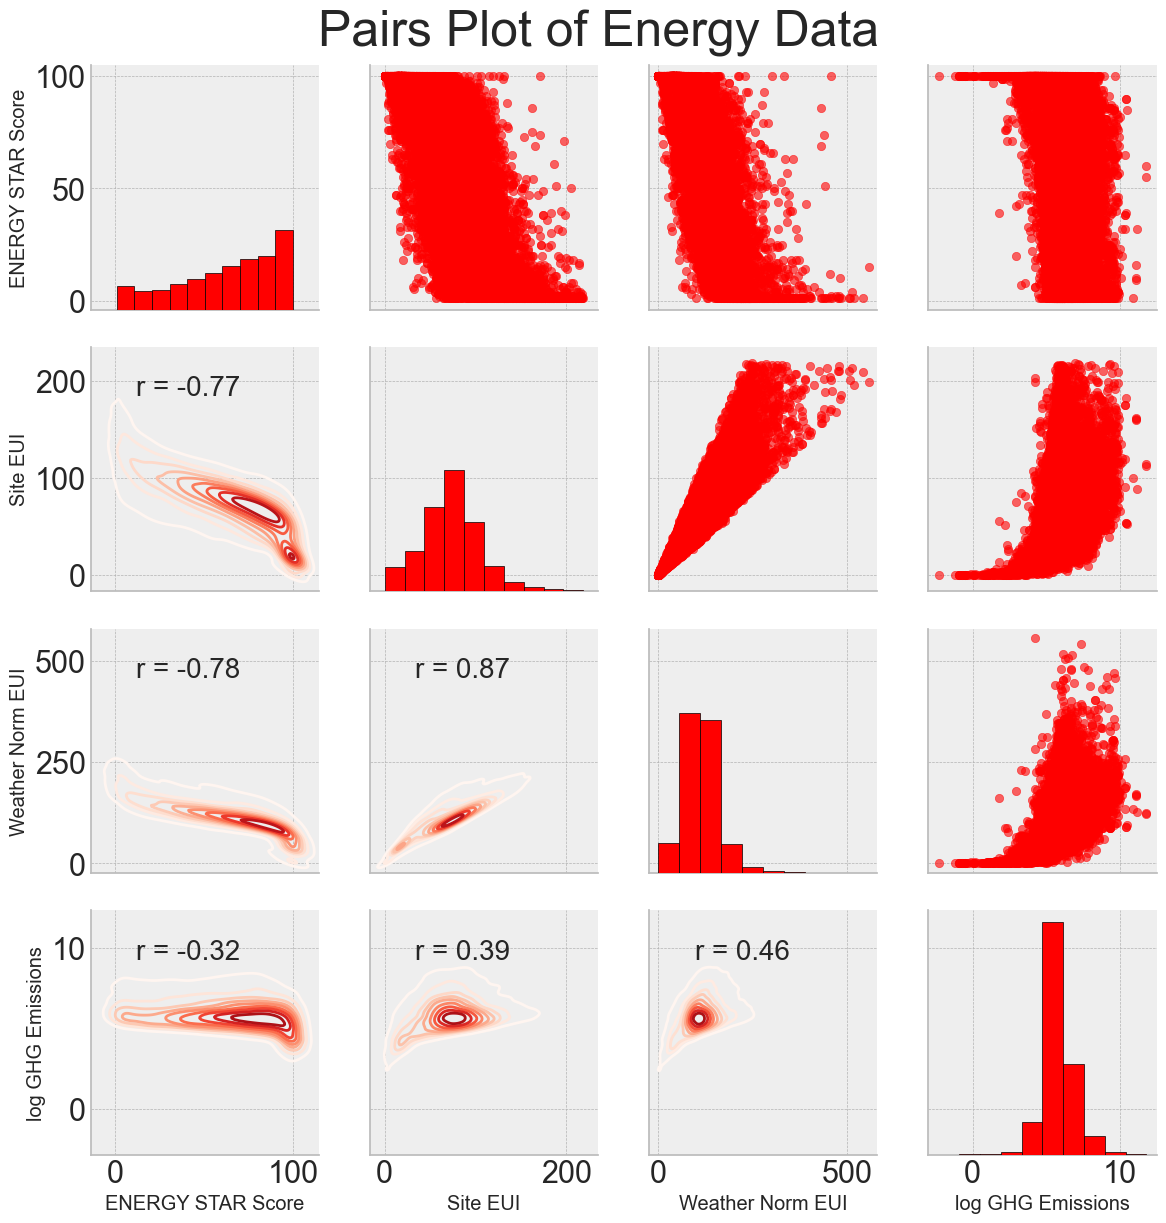

In [29]:
# Extract the columns to plot
plot_data = features[['ENERGY STAR Score', 'Site EUI (kBtu/ft²)', 
                      'Weather Normalized Source EUI (kBtu/ft²)', 
                      'log_Total (Location-Based) GHG Emissions (Metric Tons CO2e)']]

# Replace inf with nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Rename columns for cleaner plot labels
plot_data = plot_data.rename(columns={
    'Site EUI (kBtu/ft²)': 'Site EUI',
    'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI',
    'log_Total (Location-Based) GHG Emissions (Metric Tons CO2e)': 'log GHG Emissions'
})

# Drop rows with missing values
plot_data = plot_data.dropna()

# Function to annotate correlation
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate(f"r = {r:.2f}", xy=(.2, .8), xycoords=ax.transAxes, size=20)

# Create the PairGrid
grid = sns.PairGrid(data=plot_data, height=3)

# Map plots to upper, diagonal, and lower
grid.map_upper(plt.scatter, color='red', alpha=0.6)
grid.map_diag(plt.hist, color='red', edgecolor='black')
grid.map_lower(corr_func)
grid.map_lower(sns.kdeplot, cmap='Reds')

# Add overall title
plt.suptitle('Pairs Plot of Energy Data', size=36, y=1.02)


The energy score also exhibits a strong correlation with weather-normalized source EUI. The log GHG emissions is the only figure here with a flat density plot (lower-left corner). 

# Feature Engineering and Selection

Now we can move on to engineering a set of features for use in machine learning models based on the results of the EDA. In particular, we learned the following from EDA which can help us in engineering/selecting features:

* The score distribution varies by building type and to a lesser extent by borough. Although we will focus on numerical features, we should also include these two categorical features in the model. 
* Taking the log transformation of features does not result in significant increases in the linear correlations between features and the score


Before we get any further, we should define what feature engineering and selection are! These definitions are informal and have considerable overlap, but I like to think of them as two separate processes:

* __[Feature Engineering](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)__: The process of taking raw data and extracting or creating new features that allow a machine learning model to learn a mapping beween these features and the target. This might mean taking transformations of variables, such as we did with the log and square root, or one-hot encoding categorical variables so they can be used in a model. Generally, I think of feature engineering as __adding__ additional features derived from the raw data.
* __[Feature Selection](https://machinelearningmastery.com/an-introduction-to-feature-selection/)__: The process of choosing the most relevant features in your data. "Most relevant" can depend on many factors, but it might be something as simple as the highest correlation with the target, or the features with the [most variance](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html). In feature selection, we remove features that do not help our model learn the relationship between features and the target. This can help the model generalize better to new data and results in a more interpretable model. Generally, I think of feature selection as __subtracting__ features so we are left with only those that are most important.

Feature engineering and selection are iterative processes that will usually require several attempts to get right. Often we will use the results of modeling, such as the feature importances from a random forest, to go back and redo feature selection, or we might later discover relationships that necessitate creating new variables. Moreover, these processes usually incorporate a mixture of domain knowledge and statistical qualitites of the data.

[Feature engineering and selection](https://www.featurelabs.com/blog/secret-to-data-science-success/) often has the highest returns on time invested in a machine learning problem. It can take quite a while to get right, but is often more important than the exact algorithm and hyperparameters used for the model. If we don't feed the model the correct data, then we are setting it up to fail and we should not expect it to learn! 

In this project, we will take the following steps for feature engineering:

* Select only the numerical variables and two categorical variables (borough and property use type)
* Add in the log transformation of the numerical variables
* One-hot encode the categorical variables

For feature selection, we will do the following:

* Remove [collinear features](https://statinfer.com/204-1-9-issue-of-multicollinearity-in-python/)

We will discuss collinearity (also called [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)) when we get to that process! 

The following code selects the numeric features, adds in log transformations of all the numeric features, selects and one-hot encodes the categorical features, and joins the sets of features together. 

In [30]:
# Copy the original data
features = data.copy()
for each in features.columns:
    print(each)
print(features.columns)

units = ['ft', 'kBtu', 'Number of', 'Percent', 'Hours', 'gal', 'Tons', 'kWh', 'ENERGY STAR Score', 'kgal']

for col in features.columns:
    # check if there are any units or any other indication that this column is numeric
    for token in units:
        if token in col:
            try:
                features[col] = features[col].astype(float)
            except:
                print(f"Couldn't convert column '{col}'.")


# Select the numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns
print(numeric_cols)
numeric_subset = data[numeric_cols]
#numeric_subset = data.select_dtypes('number')

# Create columns with log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'score':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
        
# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

print(features.shape)

Calendar Year
Property Name
Parent Property ID
Parent Property Name
Year Ending
NYC Borough, Block and Lot (BBL)
NYC Building Identification Number (BIN)
Address 1
City
Postal Code
Primary Property Type - Self Selected
Primary Property Type - Portfolio Manager-Calculated
National Median Reference Property Type
List of All Property Use Types (GFA) (ft²)
Largest Property Use Type
Largest Property Use Type - Gross Floor Area (ft²)
Year Built
Construction Status
Number of Buildings
Occupancy
Metered Areas (Energy)
Metered Areas (Water)
ENERGY STAR Score
National Median ENERGY STAR Score
Eligible for Certification for Report PED (Y/N)
Site EUI (kBtu/ft²)
Weather Normalized Site EUI (kBtu/ft²)
National Median Site EUI (kBtu/ft²)
Site Energy Use (kBtu)
Weather Normalized Site Energy Use (kBtu)
Electricity - Weather Normalized Site Electricity Use (Grid and Onsite Renewables) (kWh)
Electricity - Weather Normalized Site Electricity Intensity (Grid and Onsite Renewables) (kWh/ft²)
Natural Gas - 

/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zepyoorkhechadoorian/Documents/compuFlair/Week_6/.venv/lib/python3.12/site-packages/pandas/core/ar

At this point, we have 11319 observations (buildings) with 103 different features (one column is the score). Not all of these features are likely to be important for predicting the score, and several of these features are also redundant because they are highly correlated. We will deal with this second issue below. 

## Remove Collinear Features

Highly [collinear features](http://psychologicalstatistics.blogspot.com/2013/11/multicollinearity-and-collinearity-in.html) have a significant correlation coefficent between them. For example, in our dataset, the `Site EUI` and `Weather Norm EUI` are highly correlated because they are just slightly different means of calculating the energy use intensity. We touched upon this earlier when making correlation coefficients, but we can observe the collinearity more directly with a scatter plot.

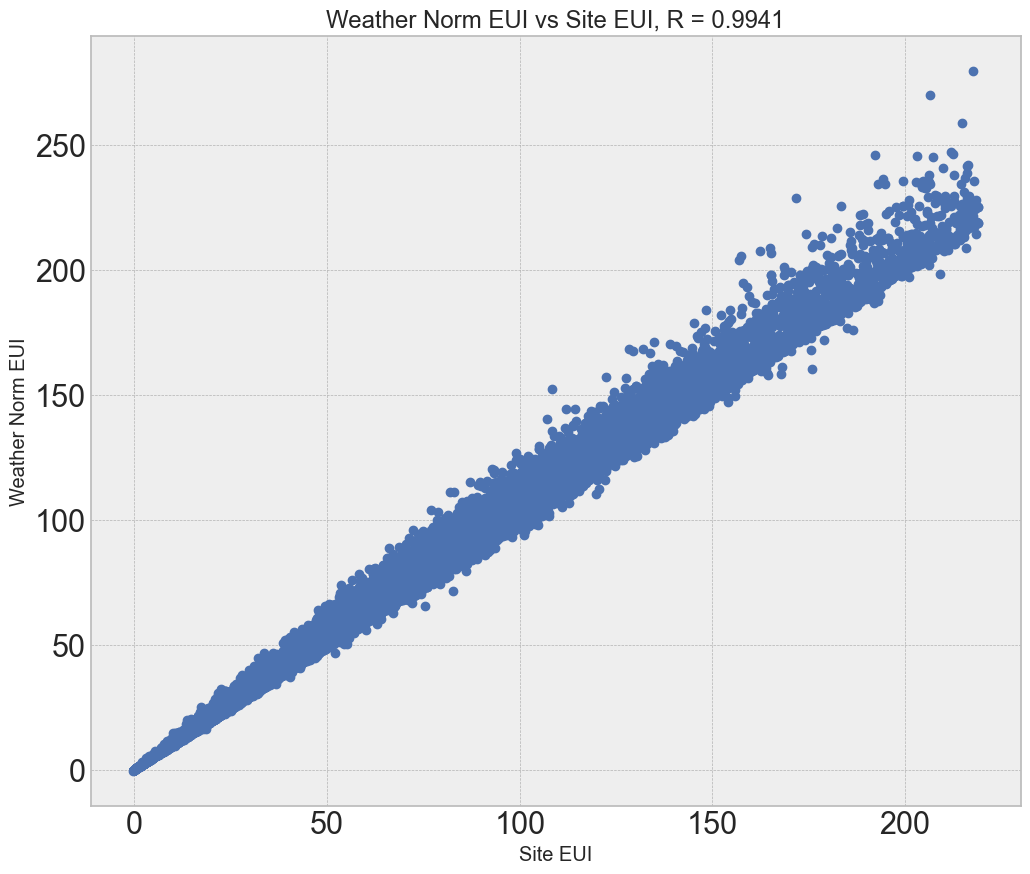

In [31]:
plot_data = data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna()

plt.plot(plot_data['Site EUI (kBtu/ft²)'], plot_data['Weather Normalized Site EUI (kBtu/ft²)'], 'bo')
plt.xlabel('Site EUI'); plt.ylabel('Weather Norm EUI')
plt.title('Weather Norm EUI vs Site EUI, R = %0.4f' % np.corrcoef(data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna(), rowvar=False)[0][1]);

While variables in a dataset are usually correlated to a small degree, highly collinear variables can be redundant in the sense that we only need to retain one of the features to give our model the necessary information.

Removing collinear features is a method to reduce model complexity by decreasing the number of features and can help to increase model generalization.  It can also help us to interpret the model because we only have to worry about a single variable, such as EUI, rather than how both EUI and weather normalized EUI affect the score. 

There are a number of methods for removing collinear features, such as using the [Variance Inflation Factor](http://www.statisticshowto.com/variance-inflation-factor/). We will use a simpler metric, and remove features that have a correlation coefficient above a certain threshold with each other (not with the score because we want variables that are highly correlated with the score!) For a more thorough discussion of removing collinear variables, check out [this notebook on Kaggle](https://www.kaggle.com/robertoruiz/dealing-with-multicollinearity/code).

The following code removes the collinear features based on a threshold we select for the correlation coefficients by removing one of the two features that are compared. It also prints the correlations that it removes so we can see the effect of adjusting the threshold. We will use a threshold of 0.6 which removes one of a pair of features if the correlation coefficient between the features exceeds this value. 

Again, I did not actually write this code from scratch, but rather adapted it from a [Stack Overflow answer](https://stackoverflow.com/a/43104383)

In [38]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        x: pandas dataframe
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between Energy Star Score
    y = x['ENERGY STAR Score']
    x = x.drop(columns = ['ENERGY STAR Score'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    # Manually drop other correlated columns
    x = x.drop(columns = ['Weather Normalized Site EUI (kBtu/ft²)', 
                          'Largest Property Use Type - Gross Floor Area (ft²)'])
    # Add the score back in to the data
    x['ENERGY STAR Score'] = y
               
    return x


In [39]:
# Remove the collinear features above a specified correlation coefficient
features = remove_collinear_features(features, 0.6);

# Remove any columns with all na values
features  = features.dropna(axis=1, how = 'all')
features.shape


(58251, 117)

Our final dataset now has 64 features (one of the columns is the target). This is still quite a few, but mostly it is because we have one-hot encoded the categorical variables. Moreover, while a large number of features may be problematic for models such as linear regression, models such as the random forest perform implicit feature selection and automatically determine which features are important during training. There are other feature selection steps to take, but for now we will keep all the features we have and see how the model performs.

#### Additional Feature Selection

There are plenty of more methods for [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html). Some popular methods include [principal components analysis (PCA)](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) which transforms the features into a reduced number of dimensions that preserve the greatest variance, or [independent components analysis (ICA)](http://cs229.stanford.edu/notes/cs229-notes11.pdf) which aims to find the independent sources in a set of features. However, while these methods are effective at reducing the number of features, they create new features that have no physical meaning and hence make interpreting a model nearly impossible. 

These methods are very helpful for dealing with high-dimensional data and I would suggest [reading more on the topic](https://machinelearningmastery.com/feature-selection-machine-learning-python/) if you plan on dealing with machine learning problems! 

## Split Into Training and Testing Sets

In machine learning, we always need to separate our features into two sets:

1. __Training set__ which we provide to our model during training along with the answers so it can learn a mapping between the features and the target. 
2. __Testing set__ which we use to evaluate the mapping learned by the model. The model has never seen the answers on the testing set, but instead, must make predictions using only the features. As we know the true answers for the test set, we can then compare the test predictions to the true test targets to ghet an estimate of how well our model will perform when deployed in the real world. 

For our problem, we will first extract all the buildings without an Energy Star Score (we don't know the true answer for these buildings so they will not be helpful for training or testing). Then, we will split the buildings with an Energy Star Score into a testing set of 30% of the buildings, and a training set of 70% of the buildings. 

Splitting the data into a random training and testing set is simple using scikit-learn. We can set the random state of the split to ensure consistent results.

In [40]:
# Extract the buildings with no score and the buildings with a score
no_score = features[features['ENERGY STAR Score'].isna()]
score = features[features['ENERGY STAR Score'].notnull()]

print(no_score.shape)
print(score.shape)

(9815, 117)
(48436, 117)


In [41]:
# Separate out the features and targets
features = score.drop(columns='ENERGY STAR Score')
targets = pd.DataFrame(score['ENERGY STAR Score'])

# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(33905, 116)
(14531, 116)
(33905, 1)
(14531, 1)


We have 9815 properties with no score, 33905 buildings with a score in the training set, and 14531 buildings with a score in the testing set. We have one final step to take in this notebook: determining a naive baseline for our models to beat! 

# Establish a Baseline

It's important to establish a naive baseline before we beginning making machine learning models. If the models we build cannot outperform a naive guess then we might have to admit that machine learning is not suited for this problem. This could be because we are not using the right models, because we need more data, or because there is a simpler solution that does not require machine learning. Establishing a baseline is crucial so we do not end up building a machine learning model only to realize we can't actually solve the problem.

For a regression task, a good naive baseline is to predict the median value of the target on the training set for all examples on the test set. This is simple to implement and sets a relatively low bar for our models: if they cannot do better than guessing the medin value, then we will need to rethink our approach. 

## Metric: Mean Absolute Error

There are a number of metrics used in machine learning tasks and it can be [difficult to know which one to choose](https://www.analyticsvidhya.com/blog/2016/02/7-important-model-evaluation-error-metrics/). Most of the time it will depend on the particular problem and if you have a specific goal to optimize for. I like [Andrew Ng's advice to use a single real-value performance metric](https://www.coursera.org/learn/machine-learning-projects/lecture/wIKkC/single-number-evaluation-metric) in order to compare models because it simplifies the evaluate process. Rather than calculating multiple metrics and trying to determine how important each one is, we should use a single number. In this case, because we doing regression, the [__mean absolute error__](https://people.duke.edu/~rnau/compare.htm) is an appropriate metric. This is also interpretable because it represents the average amount our estimate if off by in the same units as the target value. 

The function below calculates the mean absolute error between true values and predictions.

In [45]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

Now we can make the median guess and evaluate it on the test set.

In [46]:
baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 68.00
Baseline Performance on the test set: MAE = 23.4907


This shows our average estimate on the test set is off by about 25 points. The scores are between 1 and 100 so this means the average error from a naive method if about 25%. The naive method of guessing the median training value provides us a low baseline for our models to beat! 

# Conclusions

In this notebook, we carried out the first three [steps of a machine learning](https://towardsdatascience.com/the-7-steps-of-machine-learning-2877d7e5548e?gi=30cd995093a9) problem:

1. Cleaned and formatted the raw data 
2. Performed an exploratory data analysis
3. Developed a set of features to train our model using feature engineering and feature selection

We also completed the crucial task of establishing a baseline metric so we can determine if our model is better than guessing! 

In the next notebook, we will focus on implementing several machine learning methods, selecting the best model, and optimizing it for our problem using hyperparameter tuning with cross validation. As a final step here, we will save the datasets we developed to use again in the next part. 

In [47]:
import os

# Ensure the data directory exists
os.makedirs('../data', exist_ok=True)

# Now save the files
no_score.to_csv('../data/no_score.csv', index=False)
X.to_csv('../data/training_features.csv', index=False)
X_test.to_csv('../data/testing_features.csv', index=False)
y.to_csv('../data/training_labels.csv', index=False)
y_test.to_csv('../data/testing_labels.csv', index=False)


In [ ]:
g